In [1]:
from skimage.io import imread
from skimage import morphology, measure
import os, glob, tqdm, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
sys.path.append(os.path.join('..','funcs'))
import funcs
rc('font', size=15)
rc('font', family='Arial')
# rc('font', serif='Times')
rc('pdf', fonttype=42)
# rc('text', usetex=True)


In [20]:
def filter_close2supertrans(props):

    transfected = props[props.transfected]
    supertransfected = props[props.supertransfected]
    
#     plt.figure()
#     plt.xlim(0,30000)
#     plt.ylim(0,30000)
#     plt.plot(transfected['centroid-0'].values,transfected['centroid-1'].values,'ob')
#     plt.plot(supertransfected['centroid-0'].values,supertransfected['centroid-1'].values,'or',alpha=1)

    ps = np.transpose(np.array([supertransfected['centroid-0'], supertransfected['centroid-1']]))
    props['close2super'] = False
    for i, cell in transfected.iterrows():
        p = np.array([cell['centroid-0'], cell['centroid-1']])
        d = p-ps
        d = np.sqrt(np.sum(d**2,1))
        if np.min(d) < 10*np.mean(np.sqrt(props.area/np.pi)):
#             plt.plot(cell['centroid-0'],cell['centroid-1'],'og',alpha=.51)
            props.loc[i,'transfected'] = False
            props.loc[i,'close2super'] = True
#             print('Close!')
            
    return props

def filter_close2brightspot(props, X, Y):

    transfected = props[props.transfected]
    supertransfected = props[props.supertransfected]
    
    ps = np.transpose(np.array([supertransfected['centroid-0'], supertransfected['centroid-1']]))
    props['close2brightspot'] = False
    for i, cell in transfected.iterrows():
        cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
        cell_img = np.moveaxis(cell_img, -1, 0)

        cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
        cell_mask = np.pad(cell_mask,1)
        cell_mask = morphology.binary_erosion(cell_mask==cell.label,morphology.disk(4))
        cell_mask = cell_mask[1:-1,1:-1]
        
        fluo_in = cell_img[2].flatten()
        fluo_in = fluo_in[cell_mask.flatten()==True]
        fluo_in = np.mean(fluo_in)

        fluo_out = cell_img[2].flatten()
        fluo_out = fluo_out[cell_mask.flatten()==False]
        fluo_out = np.mean(fluo_out)

        if fluo_out>fluo_in:
            props.loc[i,'transfected'] = False
            props.loc[i,'close2brightspot'] = True
#             print('Close!')
            
    return props
    
# props
# filter_close2supertrans(props)

First, define the experiment folder (it depends on whether you are using local machine or server workstation).
So far, the analysis can be run on a single well of a single ibidi slide at a time. In this case we chose 'coated-wt-triton'

In [21]:
pc = os.environ['COMPUTERNAME']
if pc=='PCBA-TRIVEDI03': # my Razer
    folder_raw = os.path.join('E:',os.sep,'immuno_NMG')
elif pc=='PCBA-TRIVEDI02': # workstation
    folder_raw = os.path.join('Y:',os.sep,'Nicola_Gritti','raw_data','immuno_NMG')

exp_folder = os.path.join('2021-02-05_NGM_rep1')

resultFolder = os.path.join(folder_raw, exp_folder, 'results')

down=1
imgName = 'rep1_B01-stitched_%d%d.tif'%(down,down)

Next, define which channels are available in the images and the color you want to have them displayed with.
In this case, the membrane marker is not present because we remove it at stitching stage...

In [22]:
channels = ['Bright field','DAPI','Trim28','Sepdb1']
colors = ['black','blue','green','orange']

Read in the csv file containing the properties of the cells from the StarDist segmentation and skimage-measureprops function (that is, from the previous script).
Also, load the full image and the mask generated by the segmentation

In [23]:
# load cell props
print('Loading cell props...')
props = pd.read_csv(os.path.join(resultFolder,'props_'+os.path.splitext(imgName)[0]+'.csv'))
nch = len([i for i in props.keys() if 'mean_intens' in i])
print('Done. Found %d cells with %d features'%(len(props.label), len(props.keys())))

# load image
print('Loading image...')
X = imread(os.path.join(resultFolder,imgName))
print('Done.',X.shape)

# load image
print('Loading mask...')
maskName = 'mask_'+imgName
Y = imread(os.path.join(resultFolder,maskName))
print('Done.',Y.shape)


Loading cell props...
Done. Found 35396 cells with 26 features
Loading image...
Done. (29200, 29200, 4)
Loading mask...
Done. (29200, 29200)


In [24]:
props.head()

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,mean_intensity-2,mean_intensity-3,min_intensity-0,min_intensity-1,min_intensity-2,min_intensity-3,max_intensity-0,max_intensity-1,max_intensity-2,max_intensity-3
0,0,rep1_B01-stitched_11.tif,1,0,6649,52,6686,24.958416,6667.311551,1515,...,171.806601,224.296370,1968,237,134,116,2454,763,222,342
1,1,rep1_B01-stitched_11.tif,2,0,13072,37,13116,17.458004,13093.106246,1393,...,213.393396,261.967696,1758,277,163,117,2538,967,300,374
2,2,rep1_B01-stitched_11.tif,3,0,15035,34,15073,14.108000,15054.668000,1000,...,182.609000,233.644000,1898,182,137,114,2640,541,280,348
3,3,rep1_B01-stitched_11.tif,4,1,14069,57,14119,29.095514,14093.921852,2073,...,169.190545,237.462132,1841,205,130,119,2825,670,228,414
4,4,rep1_B01-stitched_11.tif,5,1,14303,51,14352,25.961138,14326.578544,1827,...,166.576902,227.538041,1890,195,118,106,2610,712,207,361


In [25]:
print(props.keys())
print('Cells:', len(props.label))

Index(['Unnamed: 0', 'fileName', 'label', 'bbox-0', 'bbox-1', 'bbox-2',
       'bbox-3', 'centroid-0', 'centroid-1', 'area', 'perimeter',
       'minor_axis_length', 'major_axis_length', 'eccentricity',
       'mean_intensity-0', 'mean_intensity-1', 'mean_intensity-2',
       'mean_intensity-3', 'min_intensity-0', 'min_intensity-1',
       'min_intensity-2', 'min_intensity-3', 'max_intensity-0',
       'max_intensity-1', 'max_intensity-2', 'max_intensity-3'],
      dtype='object')
Cells: 35396


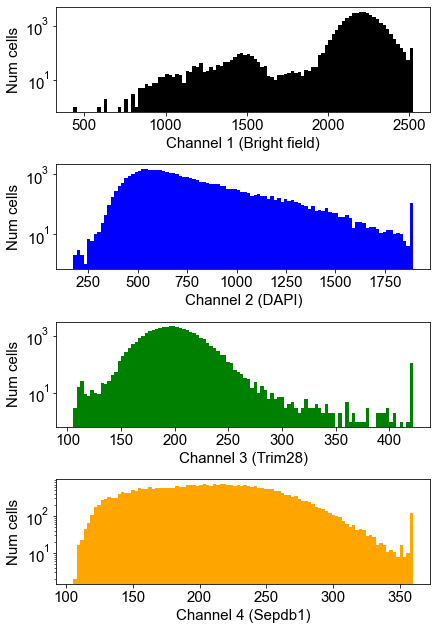

In [26]:
# plot of distributions
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(6,9))
fig.subplots_adjust(top=0.99, hspace=0.5, bottom=0.1, right=0.99)
for i in range(nch):
    data = props['mean_intensity-%d'%i]
    data = np.clip(data,0,np.percentile(data, 99.7))
    ax[i].hist(data, bins=100, color=colors[i])
    ax[i].set_xlabel('Channel %d (%s)'%(i+1,channels[i]))
    ax[i].set_ylabel('Num cells')
    ax[i].set_yscale('log')
plt.show()

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_histogram.png'),dpi=300)

Transfected cells: 43
Not transfected cells: 35353
Percentage transfected: 0.12


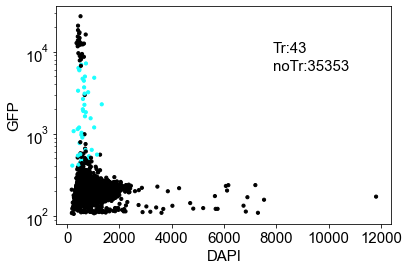

In [29]:
# determine cutoff to define cells that were successfully transfected
# use the gfp channel to determine threshold.
gfp = props['mean_intensity-%d'%2].values
dapi = props['mean_intensity-%d'%1].values

# Assume bimodal distribution (negative cells + positive cells) and use KMeans clustering with 2 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)

# cluster the data points
kmeans.fit(gfp.reshape(-1,1))
y_kmeans = kmeans.predict(gfp.reshape(-1,1))

# custom threshold
is_trans = (gfp>400)&(gfp<8000)
is_sup_trans = gfp>8000

# visualize
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.0, 0.0, 0.0), (0,0,.5), (.2, .2, 1.), (.1,1.,1.)] # Experiment with this
cm = LinearSegmentedColormap.from_list('test', colors, N=255)

# assign cluster to cells
props['transfected'] = is_trans.astype(bool)
props['supertransfected'] = is_sup_trans.astype(bool)

props = filter_close2supertrans(props)
props = filter_close2brightspot(props,X,Y)

fig, ax = plt.subplots()
ax.scatter(dapi, gfp, c=props.transfected, s=10, cmap=cm)
plt.yscale('log')
ax.set_xlabel('DAPI')
ax.set_ylabel('GFP')
ax.text(np.max(props['mean_intensity-1'])*2/3,10000,'Tr:'+str(len(props[props.transfected])))
ax.text(np.max(props['mean_intensity-1'])*2/3,6000,'noTr:'+str(len(props[props.transfected==False])))

print('Transfected cells:', len(props[props.transfected]))
print('Not transfected cells:', len(props[props.transfected==False]))
print('Percentage transfected: %.2f'%(100*(len(props[props.transfected])/(len(props.label)))))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_transfected.png'),dpi=300)

In [30]:
props

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,min_intensity-2,min_intensity-3,max_intensity-0,max_intensity-1,max_intensity-2,max_intensity-3,transfected,supertransfected,close2super,close2brightspot
0,0,rep1_B01-stitched_11.tif,1,0,6649,52,6686,24.958416,6667.311551,1515,...,134,116,2454,763,222,342,False,False,False,False
1,1,rep1_B01-stitched_11.tif,2,0,13072,37,13116,17.458004,13093.106246,1393,...,163,117,2538,967,300,374,False,False,False,False
2,2,rep1_B01-stitched_11.tif,3,0,15035,34,15073,14.108000,15054.668000,1000,...,137,114,2640,541,280,348,False,False,False,False
3,3,rep1_B01-stitched_11.tif,4,1,14069,57,14119,29.095514,14093.921852,2073,...,130,119,2825,670,228,414,False,False,False,False
4,4,rep1_B01-stitched_11.tif,5,1,14303,51,14352,25.961138,14326.578544,1827,...,118,106,2610,712,207,361,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35391,35391,rep1_B01-stitched_11.tif,35392,29169,10236,29200,10295,29185.374145,10263.474008,1462,...,127,106,1919,738,241,178,False,False,False,False
35392,35392,rep1_B01-stitched_11.tif,35393,29169,11904,29200,11944,29185.394460,11923.385864,1047,...,139,112,1593,807,241,207,False,False,False,False
35393,35393,rep1_B01-stitched_11.tif,35394,29170,13374,29200,13420,29186.452830,13398.360377,1060,...,150,110,1691,732,252,206,False,False,False,False
35394,35394,rep1_B01-stitched_11.tif,35395,29170,13463,29200,13505,29186.237811,13484.012935,1005,...,146,110,1586,598,214,187,False,False,False,False


In [31]:
transfected = props[props.transfected]
transfected.head()

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,min_intensity-2,min_intensity-3,max_intensity-0,max_intensity-1,max_intensity-2,max_intensity-3,transfected,supertransfected,close2super,close2brightspot
115,115,rep1_B01-stitched_11.tif,116,245,12476,297,12520,267.808210,12494.875561,1559,...,324,108,2651,837,1435,282,True,False,False,False
140,140,rep1_B01-stitched_11.tif,141,297,12334,345,12381,322.133002,12356.416667,1812,...,214,108,2475,330,1524,189,True,False,False,False
3289,3289,rep1_B01-stitched_11.tif,3290,3754,13404,3805,13443,3778.834738,13422.753078,1543,...,216,124,2609,1281,766,335,True,False,False,False
5010,5010,rep1_B01-stitched_11.tif,5011,5186,10066,5235,10105,5210.497973,10084.293919,1480,...,563,135,2656,945,3270,361,True,False,False,False
5091,5091,rep1_B01-stitched_11.tif,5092,5240,10086,5289,10133,5265.080674,10109.317881,1661,...,745,130,2686,941,6743,368,True,False,False,False


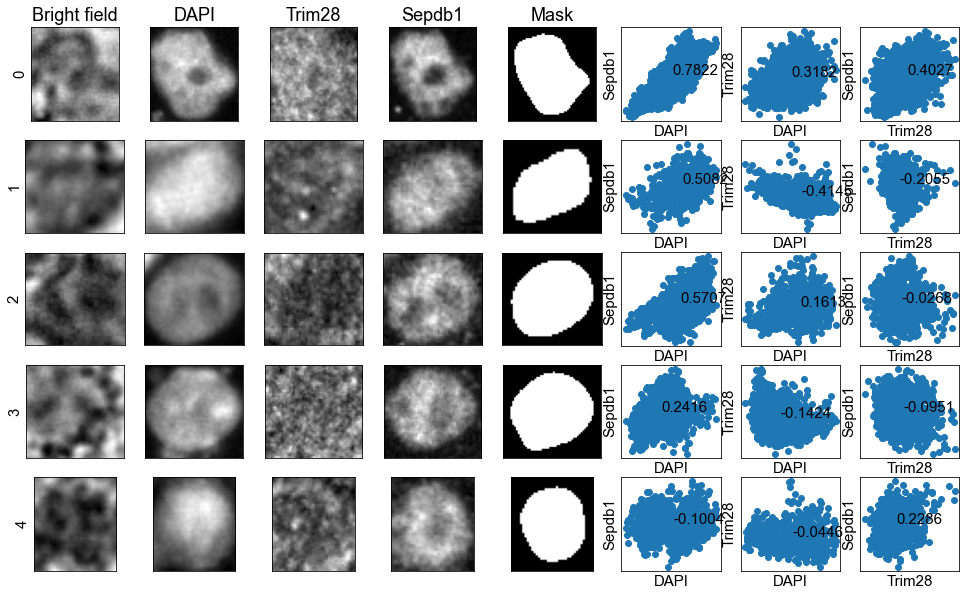

In [33]:
n_sample = 5
not_transfected_sample = props[[not i for i in props.transfected.values]].sample(n=n_sample) 

fig,ax=plt.subplots(n_sample,len(channels)+4,figsize=(15,2*n_sample))
plt.subplots_adjust(hspace=0.2,right=0.99)

i=0
for idx, cell in not_transfected_sample.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = np.pad(cell_mask,1)
    cell_mask = morphology.binary_erosion(cell_mask==cell.label,morphology.disk(4))
    cell_mask = cell_mask[1:-1,1:-1]

    for j in range(len(channels)):
        ax[i,j].imshow(cell_img[j], cmap='gray')#,clim=(0,5000))
    ax[i,len(channels)].imshow(cell_mask, cmap='gray')
    ax[i,0].set_ylabel(i)

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==True]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==True]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)

    sepdb1 = cell_img[3].flatten()
    sepdb1 = sepdb1[cell_mask.flatten()==True]
    sepdb1 = (sepdb1-np.mean(sepdb1))/np.mean(sepdb1)
    
    ax[i,len(channels)+1].scatter(dapi,sepdb1)
    ax[i,len(channels)+1].set_xlabel('DAPI')
    ax[i,len(channels)+1].set_ylabel('Sepdb1')
    ax[i,len(channels)+1].text(0,0,'%.04f'%np.corrcoef(dapi,sepdb1)[0,1])

    ax[i,len(channels)+2].scatter(dapi,trim28)
    ax[i,len(channels)+2].set_xlabel('DAPI')
    ax[i,len(channels)+2].set_ylabel('Trim28')
    ax[i,len(channels)+2].text(0,0,'%.04f'%np.corrcoef(dapi,trim28)[0,1])

    ax[i,len(channels)+3].scatter(trim28,sepdb1)
    ax[i,len(channels)+3].set_xlabel('Trim28')
    ax[i,len(channels)+3].set_ylabel('Sepdb1')
    ax[i,len(channels)+3].text(0,0,'%.04f'%np.corrcoef(trim28,sepdb1)[0,1])

    i+=1

for j in range(len(channels)):
    ax[0,j].set_title(channels[j])
#     plt.axis('off')
ax[0,len(channels)].set_title('Mask')

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_exampleImages.png'),dpi=300)

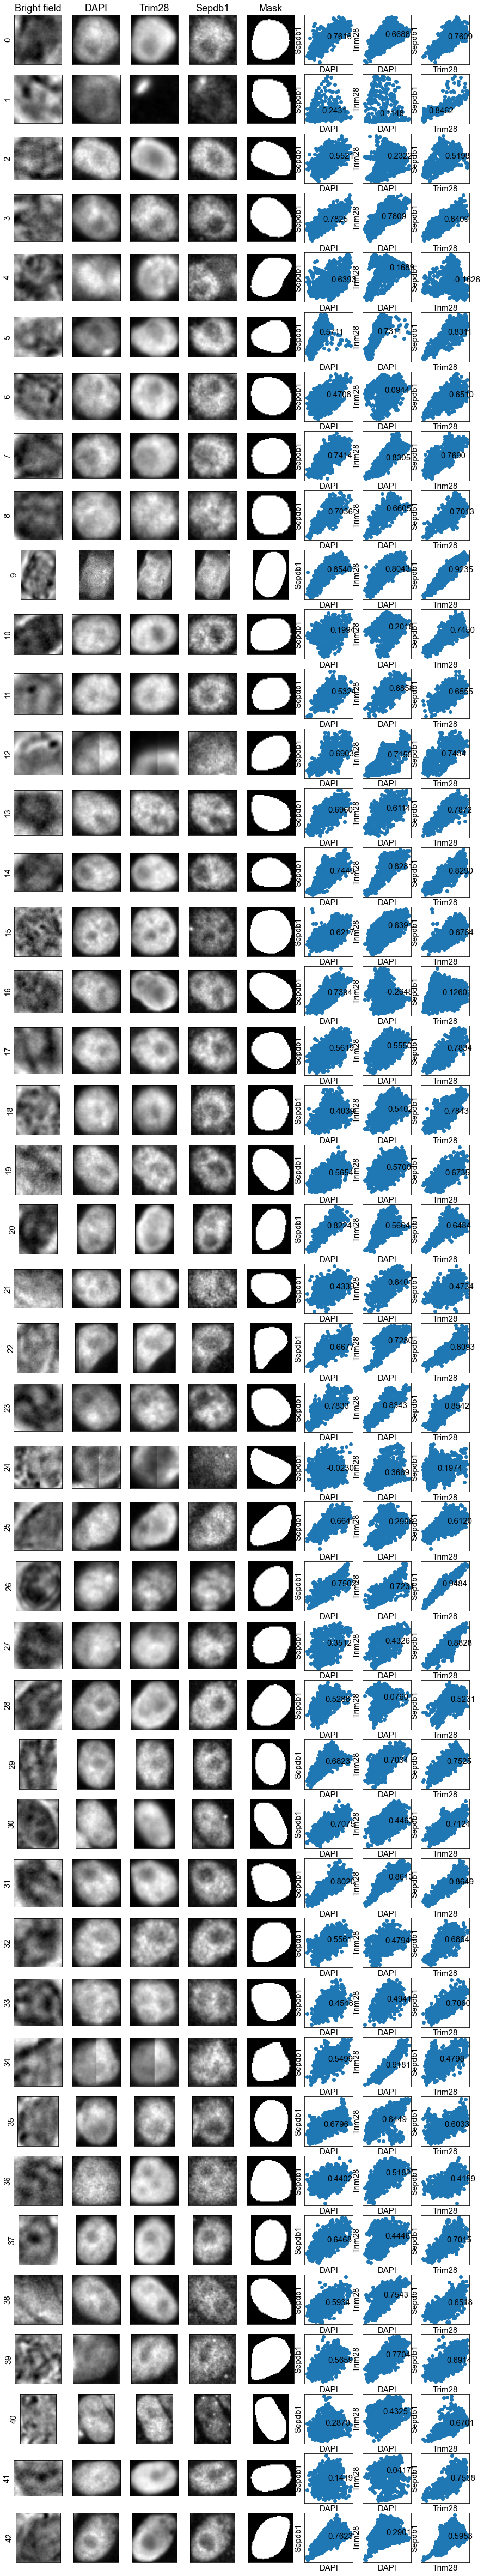

In [34]:
n_sample = len(transfected.label)
transfected_sample = transfected.sample(n=n_sample) 

if n_sample <= 1:
    n_sample += 1
fig,ax=plt.subplots(n_sample,len(channels)+4,figsize=(15,2*n_sample))

i=0
for idx, cell in transfected_sample.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = np.pad(cell_mask,1)
    cell_mask = morphology.binary_erosion(cell_mask==cell.label,morphology.disk(4))
    cell_mask = cell_mask[1:-1,1:-1]

    for j in range(len(channels)):
        ax[i,j].imshow(cell_img[j], cmap='gray')#,clim=(0,5000))
    ax[i,len(channels)].imshow(cell_mask, cmap='gray')
    ax[i,0].set_ylabel(i)

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==True]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==True]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)

    sepdb1 = cell_img[3].flatten()
    sepdb1 = sepdb1[cell_mask.flatten()==True]
    sepdb1 = (sepdb1-np.mean(sepdb1))/np.mean(sepdb1)
    
    ax[i,len(channels)+1].scatter(dapi,sepdb1)
    ax[i,len(channels)+1].set_xlabel('DAPI')
    ax[i,len(channels)+1].set_ylabel('Sepdb1')
    ax[i,len(channels)+1].text(0,0,'%.04f'%np.corrcoef(dapi,sepdb1)[0,1])

    ax[i,len(channels)+2].scatter(dapi,trim28)
    ax[i,len(channels)+2].set_xlabel('DAPI')
    ax[i,len(channels)+2].set_ylabel('Trim28')
    ax[i,len(channels)+2].text(0,0,'%.04f'%np.corrcoef(dapi,trim28)[0,1])

    ax[i,len(channels)+3].scatter(trim28,sepdb1)
    ax[i,len(channels)+3].set_xlabel('Trim28')
    ax[i,len(channels)+3].set_ylabel('Sepdb1')
    ax[i,len(channels)+3].text(0,0,'%.04f'%np.corrcoef(trim28,sepdb1)[0,1])

    i+=1

for j in range(len(channels)):
    ax[0,j].set_title(channels[j])
#     plt.axis('off')
ax[0,len(channels)].set_title('Mask')

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_exampleImages.png'),dpi=300)

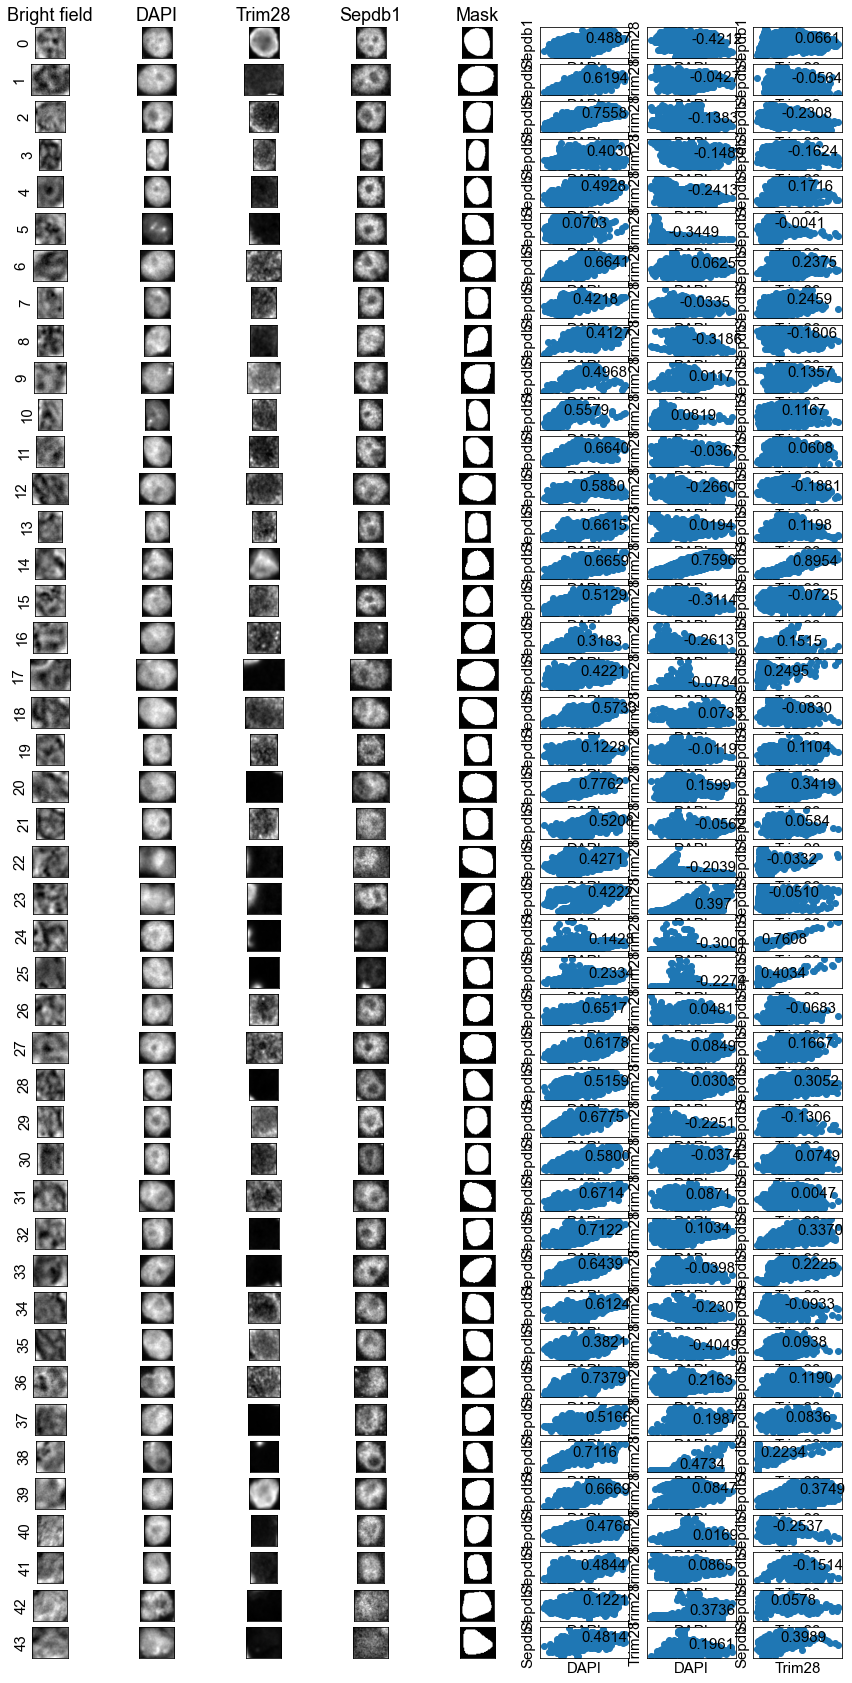

In [35]:
# n_sample = 10
close2bright = props[(props.close2super)|(props.close2brightspot)]

if n_sample <= 1:
    n_sample += 1
fig,ax=plt.subplots(len(close2bright),len(channels)+4,figsize=(15,30))

i=0
for idx, cell in close2bright.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = np.pad(cell_mask,1)
    cell_mask = morphology.binary_erosion(cell_mask==cell.label,morphology.disk(4))
    cell_mask = cell_mask[1:-1,1:-1]

    for j in range(len(channels)):
        ax[i,j].imshow(cell_img[j], cmap='gray')#,clim=(0,5000))
    ax[i,len(channels)].imshow(cell_mask, cmap='gray')
    ax[i,0].set_ylabel(i)

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==True]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==True]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)

    sepdb1 = cell_img[3].flatten()
    sepdb1 = sepdb1[cell_mask.flatten()==True]
    sepdb1 = (sepdb1-np.mean(sepdb1))/np.mean(sepdb1)
    
    ax[i,len(channels)+1].scatter(dapi,sepdb1)
    ax[i,len(channels)+1].set_xlabel('DAPI')
    ax[i,len(channels)+1].set_ylabel('Sepdb1')
    ax[i,len(channels)+1].text(0,0,'%.04f'%np.corrcoef(dapi,sepdb1)[0,1])

    ax[i,len(channels)+2].scatter(dapi,trim28)
    ax[i,len(channels)+2].set_xlabel('DAPI')
    ax[i,len(channels)+2].set_ylabel('Trim28')
    ax[i,len(channels)+2].text(0,0,'%.04f'%np.corrcoef(dapi,trim28)[0,1])

    ax[i,len(channels)+3].scatter(trim28,sepdb1)
    ax[i,len(channels)+3].set_xlabel('Trim28')
    ax[i,len(channels)+3].set_ylabel('Sepdb1')
    ax[i,len(channels)+3].text(0,0,'%.04f'%np.corrcoef(trim28,sepdb1)[0,1])

    i+=1

for j in range(len(channels)):
    ax[0,j].set_title(channels[j])
#     plt.axis('off')
ax[0,len(channels)].set_title('Mask')

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_exampleImages.png'),dpi=300)

In [36]:
corr_12 = [np.nan for i in range(len(props))] # dapi-trim28
corr_13 = [np.nan for i in range(len(props))] # dapi-sepdb1
corr_23 = [np.nan for i in range(len(props))] # trim28-sepdb1

i=0
for idx, cell in tqdm.tqdm(props.iterrows(), total=len(props.label)):
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = np.pad(cell_mask,1)
    cell_mask = morphology.binary_erosion(cell_mask==cell.label,morphology.disk(4))
    cell_mask = cell_mask[1:-1,1:-1]

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==True]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==True]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)
    
    sepdb1 = cell_img[3].flatten()
    sepdb1 = sepdb1[cell_mask.flatten()==True]
    sepdb1 = (sepdb1-np.mean(sepdb1))/np.mean(sepdb1)

    corr_12[i] = np.corrcoef(dapi,trim28)[0,1]
    corr_13[i] = np.corrcoef(dapi,sepdb1)[0,1]
    corr_23[i] = np.corrcoef(trim28,sepdb1)[0,1]
        
    i+=1

# append data to dataframe
props['corr_12'] = corr_12
props['corr_13'] = corr_13
props['corr_23'] = corr_23
    

100%|██████████████████████████████████████████████████████████████████████████▊| 35319/35396 [00:54<00:00, 601.40it/s]C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\nicol\anaconda3\envs\scaling

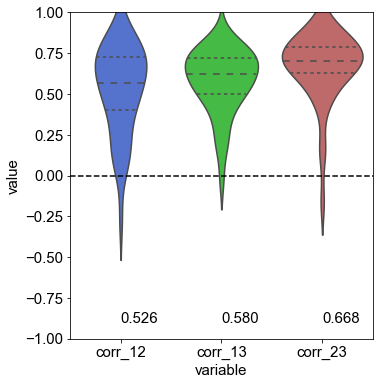

DAPI-Trim28: 0.5264021465488402 0.2644425896407828
DAPI-Spedb1: 0.5796026790243464 0.19294959930463282
Trim28-Sepdb1: 0.6679307722020416 0.20960049636872585


In [37]:
# for the sample, show correlation plots
import seaborn as sns
df = props[props.transfected]
df = df[['corr_12','corr_13','corr_23']]

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

sns.violinplot(x="variable", y="value", data=pd.melt(df), ax=ax, palette=['royalblue','limegreen','indianred'], inner='quartile')#, showfliers=False)

# sns.boxplot(x="variable", y="value", data=pd.melt(df), ax=ax, showfliers=False, palette=['royalblue','limegreen','indianred'])
# sns.swarmplot(x="variable", y="value", data=pd.melt(df), ax=ax, s=1, color='black')

ax.set_ylim(-1,1)
ax.plot([-0.5,2.5],[0,0],'--k')
ax.set_xlim(-0.5,2.5)

ax.text(0,-0.9,'%.3f'%np.mean(df['corr_12']))
ax.text(1,-0.9,'%.3f'%np.mean(df['corr_13']))
ax.text(2,-0.9,'%.3f'%np.mean(df['corr_23']))
plt.show()

print('DAPI-Trim28:', np.mean(df['corr_12']), np.std(df['corr_12']))
print('DAPI-Spedb1:', np.mean(df['corr_13']), np.std(df['corr_13']))
print('Trim28-Sepdb1:', np.mean(df['corr_23']), np.std(df['corr_23']))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrTransfected.png'),dpi=300)

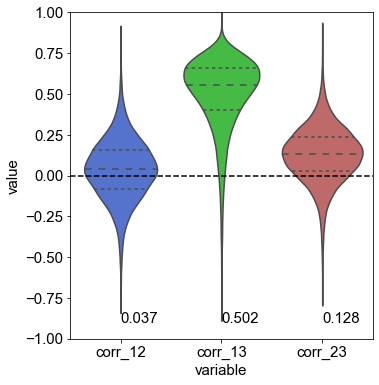

DAPI-Trim28: 0.036535979389753476 0.18739875723422328
DAPI-Spedb1: 0.5019470360621966 0.224122997244368
Trim28-Sepdb1: 0.1280624145785941 0.16935768149019143


In [38]:
# for the sample, show correlation plots
import seaborn as sns
df = props[props.transfected==False]
df = df[['corr_12','corr_13','corr_23']]

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

sns.violinplot(x="variable", y="value", data=pd.melt(df), ax=ax, palette=['royalblue','limegreen','indianred'], inner='quartile')#, showfliers=False)
# sns.boxplot(x="variable", y="value", data=pd.melt(df), ax=ax, showfliers=False, palette=['royalblue','limegreen','indianred'])
# sns.swarmplot(x="variable", y="value", data=pd.melt(df), ax=ax, s=2, color='black')

ax.set_ylim(-1,1)
ax.plot([-0.5,2.5],[0,0],'--k')
ax.set_xlim(-0.5,2.5)

ax.text(0,-0.9,'%.3f'%np.mean(df['corr_12']))
ax.text(1,-0.9,'%.3f'%np.mean(df['corr_13']))
ax.text(2,-0.9,'%.3f'%np.mean(df['corr_23']))
plt.show()

print('DAPI-Trim28:', np.mean(df['corr_12']), np.std(df['corr_12']))
print('DAPI-Spedb1:', np.mean(df['corr_13']), np.std(df['corr_13']))
print('Trim28-Sepdb1:', np.mean(df['corr_23']), np.std(df['corr_23']))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrNotTransfected.png'),dpi=300)

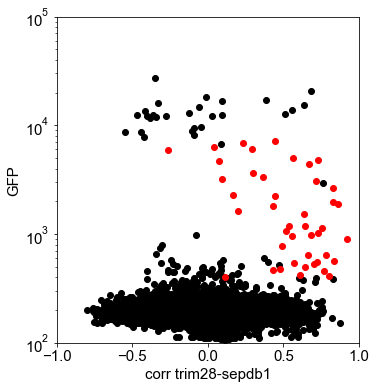

In [39]:

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

not_trasnfected = props[props.transfected==False]
ax.scatter(not_trasnfected['corr_12'],not_trasnfected['mean_intensity-2'],color='black')
transfected = props[props.transfected==True]
ax.scatter(transfected['corr_12'],transfected['mean_intensity-2'],color='red')
ax.set_xlabel('corr trim28-sepdb1')
ax.set_ylabel('GFP')
ax.set_yscale('log')
ax.set_xlim(-1,1)
ax.set_ylim(1e2, 1e5)

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrVsGFP.png'),dpi=300)